# Project 1: Document author identification

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

In [20]:
import matplotlib as mpl

%matplotlib inline
mpl.rcParams['figure.figsize'] = 18, 7
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## 1. Read the file and import data

In [3]:
import json

# read json file
def read_json(path):
    with open(path, 'r') as file:
         temp = json.load(file)
    df = pd.DataFrame(temp).T
    return df

In [4]:
train_df = read_json('comp90051-22-s1-p1/train.json')
train_df.head(5)

,venue,keywords,year,author
0,,"[64, 1, 322, 134, 136, 396, 270, 144, 476, 481...",2017,"[1605, 759]"
1,0,"[258, 260, 389, 261, 390, 396, 400, 17, 146, 2...",2013,[2182]
2,1,"[320, 454, 266, 462, 17, 339, 404, 342, 407, 2...",2007,[2176]
3,2,"[260, 132, 333, 15, 400, 272, 146, 401, 278, 3...",2013,[1107]
4,3,"[64, 385, 449, 450, 71, 73, 268, 80, 216, 25, ...",2009,[1414]


In [5]:
test_df = read_json('comp90051-22-s1-p1/test.json')
test_df.head(5)

,venue,keywords,year,coauthor,target
0,,"[260, 6, 390, 136, 7, 11, 17, 285, 288, 162, 4...",2017,[],988
1,94,"[260, 454, 137, 14, 400, 274, 339, 213, 280, 2...",2019,[1001],2123
2,31,"[390, 198, 7, 461, 462, 14, 404, 277, 24, 473,...",2014,[],1578
3,6,"[195, 6, 390, 10, 459, 464, 338, 146, 276, 466...",2010,[1347],2072
4,162,"[64, 1, 260, 457, 73, 147, 282, 27, 156, 43, 3...",2016,[1107],995


In [6]:
# print dimension for each dataframe
print(f"shape of train_df    = {train_df.shape}")
print(f"shape of test_df     = {test_df.shape}")

shape of train_df    = (26108, 4)
shape of test_df     = (2000, 5)


## 2. Create Label (make it same as test data)

In [7]:
def get_transformed_df(df):
    aus = df['author']
    transformed_lst = []
    for i in range(df.shape[0]):
        for j in aus[i]:
            temp = list(df.values[i][:-1])
            temp.append([au for au in aus[i] if au!=j])
            temp.append(j)
            transformed_lst.append(temp)
    cols = list(df.columns[:-1])
    cols.append('coauthor')
    cols.append('target')
    return pd.DataFrame(transformed_lst,columns=cols)

In [8]:
transformed_df = get_transformed_df(train_df)

In [9]:
transformed_df.head()

,venue,keywords,year,coauthor,target
0,,"[64, 1, 322, 134, 136, 396, 270, 144, 476, 481...",2017,[759],1605
1,,"[64, 1, 322, 134, 136, 396, 270, 144, 476, 481...",2017,[1605],759
2,0,"[258, 260, 389, 261, 390, 396, 400, 17, 146, 2...",2013,[],2182
3,1,"[320, 454, 266, 462, 17, 339, 404, 342, 407, 2...",2007,[],2176
4,2,"[260, 132, 333, 15, 400, 272, 146, 401, 278, 3...",2013,[],1107


## 2. Create "word embeddings" for keywords (Word2Vec using SkipGram)

In [23]:
corpus = list(transformed_df['keywords'])
max_window_size = max([len(i) for i in corpus])

In [24]:
from gensim.models.word2vec import Word2Vec

WINDOW_SIZE_KEYWORDS = 6
VECTOR_SIZE_KEYWORDS = 12

model_keywords = Word2Vec(corpus,  # previously generated walks
                 hs=1,  # use hierarchical softmax
                 sg = 1,  # use skip-gram
                 vector_size=VECTOR_SIZE_KEYWORDS,  # size of the embedding
                 window=WINDOW_SIZE_KEYWORDS,
                 workers=4,
                 seed=42)

In [25]:
# embeddings for each keyword
embedding_keywords = model_keywords.wv.vectors
embedding_keywords.shape

(500, 12)

In [26]:
# get embedding for keyword 499
# Same as "model_keywords.wv.__getitem__(499)"
model_keywords.wv.get_vector(499) 

array([ 0.10633333, -0.37958515, -0.1963936 ,  0.04065178, -0.5484793 ,
        0.5884821 ,  0.8255234 , -0.6020208 , -0.617839  , -0.64155775,
       -0.7866536 , -0.47699666], dtype=float32)

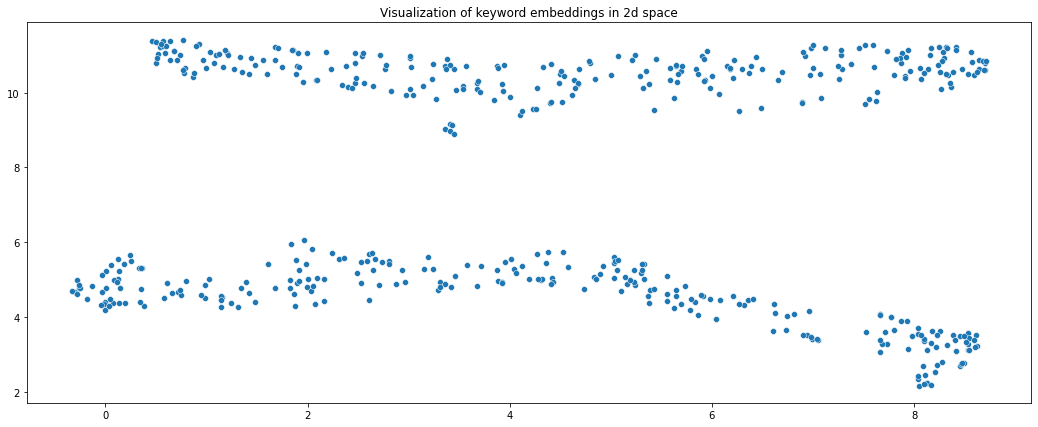

In [27]:
import umap.umap_ as umap
import seaborn as sns

# visualize keywords in 2d space
u = umap.UMAP(random_state=90051)
umap_embs_keywords = u.fit_transform(embedding_keywords)

ax = sns.scatterplot(x = umap_embs_keywords[:, 0], y = umap_embs_keywords[:, 1]).set(title="Visualization of keyword embeddings in 2d space")




- The pattern in the visualization shows there are two clusters, illustrate there are potentially two main areas of those papers

## 3. One-hot

In [10]:
import torch
def get_onehot_col(col, size, col_prefix):
    transformed_col = []
    for i in col:
        transformed_col.append(torch.zeros(size, dtype=torch.int).scatter_(0, torch.tensor(i), value=1).tolist())
    col_names = [col_prefix+'_'+str(i) for i in range(size)]
    return pd.DataFrame(transformed_col, columns=col_names)

In [11]:
transformed_df.loc[transformed_df['venue']=='',['venue']]=470
venue_transformed = get_onehot_col(transformed_df['venue'], 471, "venue")

#keywords_transformed = get_onehot_col(transformed_df['keywords'], 500, "keywords")

transformed_df['year'] = transformed_df['year']-2000
year_transformed = get_onehot_col(transformed_df['year'], 20, "year")

coauthor_transformed = get_onehot_col(transformed_df['coauthor'], 2302, "coauthor")

target_transformed = get_onehot_col(transformed_df['target'], 2302, "target")




## 3. Create word embeddings for keywords (SkipGram)

In [52]:
def convert_to_emb(lst, model):
    
    curr = []
    for i in lst:
        try:
            curr.append(model.wv.get_vector(i))
        except:
            continue
    if curr == []:
        return list([0 for i in range(model.vector_size)])
    return np.mean(np.array(curr), axis=0).tolist()


keywords_tran = []
for row in transformed_df['keywords']:
    keywords_tran.append(convert_to_emb(row, model_keywords ))

keywords_cols = ["keyword_"+str(i) for i in range(VECTOR_SIZE_KEYWORDS)]
keywords_transformed_word2vec = pd.DataFrame(keywords_tran, columns=keywords_cols)





In [53]:
keywords_transformed_word2vec.head()

,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10,keyword_11
0,0.10779,0.04545,0.18435,-0.51457,-0.39999,0.52017,0.38116,-0.80316,-0.04370,-0.02749,-0.07267,-0.17975
1,0.10779,0.04545,0.18435,-0.51457,-0.39999,0.52017,0.38116,-0.80316,-0.04370,-0.02749,-0.07267,-0.17975
2,0.14102,0.09187,0.06748,-0.44692,-0.31678,0.53614,0.33748,-0.80720,-0.01964,-0.00305,-0.02810,-0.29140
3,0.14934,0.10197,-0.07031,-0.27358,-0.24233,0.51248,0.16031,-0.87437,0.02315,-0.12109,-0.15121,-0.15526
4,0.09312,0.16307,-0.01512,-0.29342,-0.42790,0.56073,0.23019,-0.83085,0.12729,-0.22188,-0.12807,-0.04007


## 3. Combine

In [54]:

#transformed_df_comb = pd.concat([venue_transformed,keywords_transformed,keywords_transformed_tfidf,year_transformed,transformed_df['year'], coauthor_transformed],axis=1)
transformed_df_comb = pd.concat([venue_transformed,keywords_transformed_word2vec,year_transformed, coauthor_transformed],axis=1)



In [55]:
transformed_df_comb['target'] = transformed_df['target'].values

In [56]:
transformed_df_comb.head()

,venue_0,venue_1,venue_2,venue_3,venue_4,venue_5,venue_6,venue_7,venue_8,venue_9,...,coauthor_2293,coauthor_2294,coauthor_2295,coauthor_2296,coauthor_2297,coauthor_2298,coauthor_2299,coauthor_2300,coauthor_2301,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1605
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,759
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2182
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2176
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1107


In [58]:
transformed_df_comb.shape

(48000, 2806)

## 2. Train test split

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_val,y_train,   y_val = train_test_split(transformed_df_comb.iloc[:,:-1], transformed_df_comb['target'],test_size=0.2, random_state=90051)

print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape))
print("X_val   shape: {}, y_val   shape: {}".format(X_val.shape, y_val.shape))



X_train shape: (38400, 2805), y_train shape: (38400,)
X_val   shape: (9600, 2805), y_val   shape: (9600,)


In [72]:
X_val_pos = X_val
X_val_neg = X_val
y_val_pos = y_val
y_val_neg = pd.Series(np.random.choice([i for i in range(2302)], 14400))
X_val_comb = pd.concat([X_val_pos, X_val_neg],axis = 0)
y_val_comb = y_val_pos.append(y_val_neg, ignore_index=True)

true_label = [1 for i in range(X_val_pos.shape[0])]+[0 for i in range(X_val_pos.shape[0])]
print("X_val_comb shape: ", X_val_comb.shape)
print("y_val_comb shape: ", y_val_comb.shape)

X_val_comb shape:  (19200, 2805)
y_val_comb shape:  (24000,)


## 3. Model: Gaussian NB

In [98]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB


clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)

GaussianNB()

In [99]:
from sklearn.metrics import roc_auc_score

pred_NB = clf_NB.predict_proba(X_val_comb)
res = []
for i in range(len(pred_NB)):
    res.append(pred_NB[i][y_val_comb[i]])

roc_auc_score(true_label, res) # 0.7436069390190972

0.7436069390190972

## 3. Model: LR

In [77]:
from sklearn.metrics import roc_auc_score

In [78]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

- C=1

In [79]:
%%time

clf_LR_1 = LogisticRegression(multi_class="multinomial", C=1, verbose=True)
clf_LR_1.fit(X_train, y_train)      

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      6459412     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97275D+05    |proj g|=  1.36319D+02


 This problem is unconstrained.



At iterate   50    f=  1.75341D+05    |proj g|=  3.79947D+00

At iterate  100    f=  1.75320D+05    |proj g|=  2.64064D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    100    107      1     0     0   2.641D-01   1.753D+05
  F =   175319.52897649939     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
CPU times: user 55min 25s, sys: 4min 11s, total: 59min 36s
Wall time: 21min 18s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.2min finished


LogisticRegression(C=1, multi_class='multinomial', verbose=True)

In [80]:
pred_LR_1 = clf_LR_1.predict_proba(X_val_comb)
res_1 = []
for i in range(len(pred_LR_1)):
    res_1.append(pred_LR_1[i][y_val_comb[i]])

# 0.9406964916087963
roc_auc_score(true_label, res_1) # 0.9336609917534724

0.9336609917534724

- C=0.1

In [81]:
%%time

clf_LR_01 = LogisticRegression(multi_class="multinomial", C=0.1, verbose=True)
clf_LR_01.fit(X_train, y_train)      

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      6459412     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  2.97275D+05    |proj g|=  1.36319D+02

At iterate   50    f=  2.65551D+05    |proj g|=  2.39026D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     64     69      1     0     0   6.580D-02   2.656D+05
  F =   265550.50604333245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
CPU times: user 35min 3s, sys: 2min 32s, total: 37min 36s
Wall time: 13min 25s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.4min finished


LogisticRegression(C=0.1, multi_class='multinomial', verbose=True)

In [82]:
pred_LR_01 = clf_LR_01.predict_proba(X_val_comb)
res_01 = []
for i in range(len(pred_LR_01)):
    res_01.append(pred_LR_01[i][y_val_comb[i]])

roc_auc_score(true_label, res_01) # 0.8081501410590277

0.8081501410590277

## 4. Read on test data

In [92]:
test_df = read_json('comp90051-22-s1-p1/test.json')
test_df.head(5)

,venue,keywords,year,coauthor,target
0,,"[260, 6, 390, 136, 7, 11, 17, 285, 288, 162, 4...",2017,[],988
1,94,"[260, 454, 137, 14, 400, 274, 339, 213, 280, 2...",2019,[1001],2123
2,31,"[390, 198, 7, 461, 462, 14, 404, 277, 24, 473,...",2014,[],1578
3,6,"[195, 6, 390, 10, 459, 464, 338, 146, 276, 466...",2010,[1347],2072
4,162,"[64, 1, 260, 457, 73, 147, 282, 27, 156, 43, 3...",2016,[1107],995


- One hot

In [93]:
test_df.loc[test_df['venue']=='',['venue']]=470
venue_transformed_test = get_onehot_col(test_df['venue'], 471, "venue")

#keywords_transformed_test = get_onehot_col(test_df['keywords'], 500, "keywords")

test_df['year'] = test_df['year']-2000
year_transformed_test = get_onehot_col(test_df['year'], 20, "year")

coauthor_transformed_test = get_onehot_col(test_df['coauthor'], 2302, "coauthor")

target_transformed_test = get_onehot_col(test_df['target'], 2302, "target")





In [94]:
test_df

,venue,keywords,year,coauthor,target
0,470,"[260, 6, 390, 136, 7, 11, 17, 285, 288, 162, 4...",17,[],988
1,94,"[260, 454, 137, 14, 400, 274, 339, 213, 280, 2...",19,[1001],2123
2,31,"[390, 198, 7, 461, 462, 14, 404, 277, 24, 473,...",14,[],1578
3,6,"[195, 6, 390, 10, 459, 464, 338, 146, 276, 466...",10,[1347],2072
4,162,"[64, 1, 260, 457, 73, 147, 282, 27, 156, 43, 3...",16,[1107],995
...,...,...,...,...,...
1995,14,"[194, 260, 69, 73, 14, 462, 334, 17, 336, 280,...",15,[],1876
1996,5,"[64, 260, 261, 135, 7, 75, 332, 334, 15, 463, ...",16,[],1976
1997,58,"[451, 136, 459, 15, 146, 276, 342, 285, 222, 2...",4,[646],1131
1998,6,"[128, 64, 322, 260, 261, 388, 391, 455, 265, 1...",16,"[1684, 1040, 1713]",2124


- word2vec

In [95]:

keywords_tran_test = []
for row in test_df['keywords']:
    keywords_tran_test.append(convert_to_emb(row, model_keywords ))

keywords_cols = ["keyword_"+str(i) for i in range(VECTOR_SIZE_KEYWORDS)]
keywords_transformed_test_word2vec = pd.DataFrame(keywords_tran_test, columns=keywords_cols)



- combine

In [96]:
# transformed_df_comb_test = pd.concat([venue_transformed_test,keywords_transformed_test,keywords_transformed_test_tfidf,year_transformed_test,test_df['year'].reset_index(drop=True),coauthor_transformed_test],axis=1)

transformed_df_comb_test = pd.concat([venue_transformed_test,keywords_transformed_test_word2vec,year_transformed_test,coauthor_transformed_test],axis=1)
target = test_df['target']




In [97]:
transformed_df_comb_test.shape

(2000, 2805)

## 5. Fit on test data - LR
- AUC on Kaggle: 0.84515(c=1)

In [89]:
pred_LR_test = clf_LR_01.predict_proba(transformed_df_comb_test)
res_test = []
for i in range(len(pred_LR_test)):
    res_test.append(pred_LR_test[i][target[i]])


In [90]:
sample_df = pd.read_csv('comp90051-22-s1-p1/sample.csv',index_col=0)
sample_df['Predicted'] = res_test
sample_df.to_csv('predicted_LR_word2vec_lr_c1.csv')